# TODOS:
- Mechanism for selecting apo/pred; right now we are selecting at most one apo/pred by `sort_score`
- Relax with requirement of presence of apo and holo
- Agree on what out feature input and output should look like

In [63]:
%load_ext autoreload
%autoreload 2

from plinder.core.structure.structure import Structure
from plinder.core import PlinderSystem
from pathlib import Path
from rdkit import Chem
import numpy as np
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.drawOptions.addAtomIndices = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Need biotite >= 0.41

In [2]:
import biotite
biotite.__version__

'0.41.2'

# Load structure

#### load holo structure

In [3]:
# plix = "1avd__1__1.A__1.C"
plix = "1ngx__1__1.A_1.B__1.E"

ROOT_DIR = Path.home() / ".local/share"
holo_struc = Structure.load_structure(
    id=plix,
    protein_path=ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/receptor.cif",
    protein_sequence=ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/sequences.fasta",
    list_ligand_sdf_and_input_smiles=[(
        ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/ligand_files/1.E.sdf",
        # "CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O"
        "C[C@@H](COC[C@@H](C)OC[C@@H](C)OC[C@H](C)OC[C@H](C)OCC(C)OC[C@@H](C)OC[C@@H](C)OC[C@H](C)OCCOC)N"
    )]
)

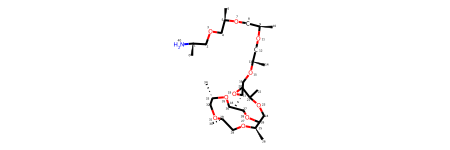

In [4]:
holo_struc.input_ligand_conformers["1.E"]

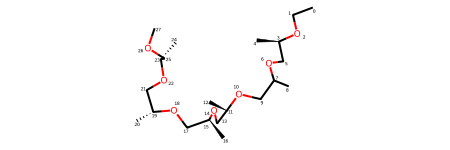

In [5]:
holo_struc.resolved_ligand_mols["1.E"]

In [6]:
conformer_stacks, resolved_stacks = holo_struc.input_ligand_conformer2resolved_stacks["1.E"]

In [7]:
conformer_stacks[0], resolved_stacks[0]

(array([37, 36, 35, 33, 34, 32, 31, 29, 30, 28, 27, 25, 26, 24, 23, 21, 22,
        20, 19, 17, 18, 16, 15, 13, 14, 12, 11,  9]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27]))

In [8]:
holo_struc.resolved_ligand_mols_coords["1.E"][resolved_stacks[0]]

array([[50.032, 41.618, 47.292],
       [48.739, 41.131, 46.61 ],
       [49.015, 39.923, 45.883],
       [47.826, 39.397, 45.206],
       [46.388, 39.474, 45.817],
       [48.102, 38.106, 44.412],
       [47.167, 37.99 , 43.328],
       [47.506, 36.863, 42.511],
       [48.464, 36.476, 41.37 ],
       [46.626, 35.645, 42.889],
       [45.211, 35.978, 42.786],
       [44.422, 34.893, 43.31 ],
       [43.299, 35.448, 44.226],
       [43.789, 34.055, 42.176],
       [43.596, 34.91 , 41.026],
       [43.287, 34.302, 39.737],
       [44.199, 33.126, 39.265],
       [41.839, 33.788, 39.755],
       [40.983, 34.919, 39.571],
       [39.632, 34.809, 40.083],
       [38.59 , 34.25 , 39.079],
       [39.208, 36.233, 40.481],
       [40.334, 36.888, 41.097],
       [40.127, 38.253, 41.523],
       [41.062, 39.292, 40.858],
       [40.369, 38.286, 43.04 ],
       [39.282, 38.975, 43.68 ],
       [39.719, 40.262, 44.144]])

In [9]:
holo_struc.input_ligand_conformer_coords["1.E"][conformer_stacks[0]]

array([[ 0.56861218, -3.64889532,  4.05331325],
       [-0.8874506 , -3.25967875,  4.14256555],
       [-1.1777044 , -2.28402451,  3.14064513],
       [-2.57050055, -2.40866274,  2.8647574 ],
       [-3.1488055 , -1.00852676,  2.82729456],
       [-2.78729672, -3.04363813,  1.50184472],
       [-2.29278202, -4.38288129,  1.48329055],
       [-1.54411486, -4.52163194,  0.27964787],
       [-2.48492856, -4.88768959, -0.84552203],
       [-0.50067745, -5.61489775,  0.42539566],
       [ 0.54067635, -5.191071  ,  1.30238488],
       [ 1.76846096, -5.41058907,  0.62077213],
       [ 2.48538857, -6.55016234,  1.30649152],
       [ 2.63732837, -4.1662141 ,  0.70924115],
       [ 2.09782155, -3.09903959, -0.06514369],
       [ 1.20504374, -2.33367856,  0.74850509],
       [ 2.00091307, -1.55937968,  1.78390256],
       [ 0.43252211, -1.33160957, -0.09258492],
       [-0.36081067, -1.94998616, -1.10353249],
       [ 0.44395581, -2.08593792, -2.27727915],
       [-0.21378768, -3.13004868, -3.150

#### load holo/apo structures

In [16]:
plix = "1avd__1__1.A__1.C"

ROOT_DIR = Path.home() / ".local/share"
holo_struc = Structure.load_structure(
    id=plix,
    protein_path=ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/receptor.cif",
    protein_sequence=ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/sequences.fasta",
    list_ligand_sdf_and_input_smiles=[(
        ROOT_DIR/f"plinder/2024-06/v2/systems/{plix}/ligand_files/1.C.sdf",
        "CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O"
    )]
)

In [17]:
apo_struc = Structure.load_structure(
    id="1avd_A",
    protein_path=ROOT_DIR/ "plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1nqn_A/superposed.cif",
    protein_sequence=ROOT_DIR/"plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta",
    structure_type="apo"
    )

#### list structure  fields

In [18]:
holo_struc.model_fields

{'id': FieldInfo(annotation=str, required=True),
 'protein_path': FieldInfo(annotation=Path, required=True),
 'protein_sequence': FieldInfo(annotation=Path, required=True),
 'list_ligand_sdf_and_input_smiles': FieldInfo(annotation=Union[list[tuple[Path, str]], NoneType], required=False, default=None),
 'protein_atom_array': FieldInfo(annotation=Union[AtomArray, NoneType], required=False, default=None),
 'ligand_mols': FieldInfo(annotation=Union[dict[str, tuple[Mol, Mol, tuple[ndarray[Any, dtype[+_ScalarType_co]], ndarray[Any, dtype[+_ScalarType_co]]], Mol, tuple[ndarray[Any, dtype[+_ScalarType_co]], ndarray[Any, dtype[+_ScalarType_co]]]]], NoneType], required=False, default=None),
 'add_ligand_hydrogens': FieldInfo(annotation=bool, required=False, default=False),
 'structure_type': FieldInfo(annotation=str, required=False, default='holo')}

#### get structure properties

In [19]:
holo_struc.get_properties()

['__fields_set__',
 'input_ligand_conformer2resolved_stacks',
 'input_ligand_conformer2smiles_stacks',
 'input_ligand_conformer_coords',
 'input_ligand_conformers',
 'input_ligand_templates',
 'input_sequence_full_atom_feat',
 'input_sequence_list_ordered_by_chain',
 'input_sequence_stacked_mask',
 'input_sequences',
 'ligand_chain_ordered',
 'model_extra',
 'model_fields_set',
 'protein_backbone_mask',
 'protein_calpha_coords',
 'protein_calpha_mask',
 'protein_chain_ordered',
 'protein_chain_uninput_sequence',
 'protein_chains',
 'protein_coords',
 'protein_n_atoms',
 'protein_sequence_from_structure',
 'protein_structure_atom_names',
 'protein_structure_b_factor',
 'protein_structure_residue_names',
 'protein_structure_residues',
 'protein_structure_sequence_fasta',
 'protein_structure_tokenized_sequence',
 'resolved_ligand_mols',
 'resolved_ligand_mols_coords',
 'resolved_ligand_structure2smiles_stacks',
 'resolved_ligand_structure_coords',
 'sequence_atom_mask']

#### Inspect holo structure

In [20]:
holo_struc.resolved_ligand_structure_atom_index_maps

AttributeError: 'Structure' object has no attribute 'resolved_ligand_structure_atom_index_maps'

In [21]:
holo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 15),
                    <class 'numpy.ndarray'> with shape (1, 15),
                ),
                (
                    <class '

#### Inspect holo ligand
Returns a chain-mapped dictionary of original_unresolved_mol, resolved_ligand_mol resolved_ligand_mol_conformer, matches


In [22]:
holo_struc.ligand_mols

{'1.C': (<rdkit.Chem.rdchem.Mol at 0x1cf2874c0>,
  (array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]),
   array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]])),
  (array([[ 9,  4,  5,  6,  7, 11,  1,  0,  3, 14, 13,  8, 12,  2]]),
   array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])),
  (array([[ 9,  4,  5,  6,  7, 11,  1,  0,  3, 14, 13,  8, 12,  2]]),
   array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]])))}

#### Inspect holo sequences
Returns a chain-mapped dictionary of sequences

In [23]:
holo_struc.input_sequences

{'1.A': 'ARKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRTQKE'}

#### Inspect holo atom array
This is the input sequence-renumbered array


In [24]:
holo_struc.protein_atom_array

array([
	Atom(np.array([31.221, 22.957, 43.101], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="N", element="N", b_factor=0.0),
	Atom(np.array([31.828, 24.118, 42.476], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CA", element="C", b_factor=0.0),
	Atom(np.array([31.979, 23.854, 41.021], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="C", element="C", b_factor=0.0),
	Atom(np.array([31.496, 24.598, 40.166], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="O", element="O", b_factor=0.0),
	Atom(np.array([33.178, 24.436, 43.069], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CB", element="C", b_factor=0.0),
	Atom(np.array([33.279, 25.867, 43.567], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CG", ele

#### Inspect unresolved input structure indices
Unresolved structure original indices with indices matching the residue number of resolved sequence

In [25]:
# holo_struc.unresolved_aligned_indices

#### Inspect unresolved input strcture sequence
Unresolved structure original indices with indices matching the residue number of resolved sequence

#### Inspect  orignal holo PDB ligand loaded from sdf

In [26]:
holo_struc.resolved_ligand_mols #resolved_ligand_mols

{'1.C': <rdkit.Chem.rdchem.Mol at 0x1cf2875a0>}

#### Inspect input  ligand loaded from smiles

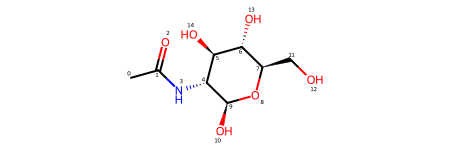

In [27]:
holo_struc.input_ligand_templates['1.C'] #resolved_ligand_mols

#### Inspect random conformer of input ligand loaded from smiles

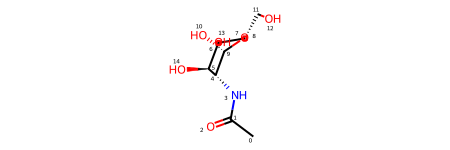

In [28]:
holo_struc.input_ligand_conformers['1.C'] 

### Compare to resolved ligand in holo

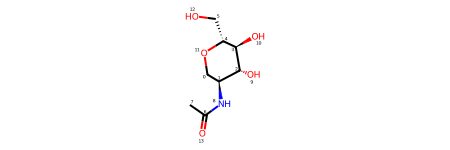

In [29]:
holo_struc.resolved_ligand_mols['1.C']

Examples

1 C  4
2 N  5
3 O  7
4 C  6
...

1, 3, 4, 5, 9
[True, False, True, True, ...]

4, 3, 1, 5, 9
[True, False, True, True, ...]


In [31]:
holo_struc.resolved_ligand_mols_coords['1.C'][[0, 1, 4]]

array([[36.097, 24.731, 18.551],
       [36.841, 24.28 , 17.298],
       [37.118, 26.889, 18.595]])

In [32]:
holo_struc.input_ligand_conformer_coords['1.C'][[4, 7, 8]]

array([[-0.19333073, -1.2131695 ,  0.82980717],
       [ 1.32665525,  0.70497923, -0.45951253],
       [ 1.31558098,  0.74846475,  0.9695246 ]])

In [34]:
holo_struc.input_ligand_conformer2smiles_stacks['1.C']

(array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]),
 array([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]]))

#### Inspect coordinates of random conformer of resolved ligand loaded from smiles

In [35]:
holo_struc.input_ligand_conformer_coords #resolved_ligand_conformers_coords

{'1.C': array([[ 1.76729127, -4.40938062,  0.64227329],
        [ 0.58549963, -3.51768802,  0.43852935],
        [-0.45362473, -3.88894251, -0.09019937],
        [ 0.81794632, -2.24941046,  0.91110352],
        [-0.19333073, -1.2131695 ,  0.82980717],
        [-0.5596095 , -0.88304756, -0.60527877],
        [-0.05113278,  0.47145509, -1.050163  ],
        [ 1.32665525,  0.70497923, -0.45951253],
        [ 1.31558098,  0.74846475,  0.9695246 ],
        [ 0.25535788,  0.02481546,  1.58952829],
        [-0.85992891,  0.87289691,  1.81248116],
        [ 1.98966528,  1.96984276, -0.9623966 ],
        [ 2.57788568,  1.73107773, -2.23050601],
        [-0.03672556,  0.5165847 , -2.46544122],
        [-1.97265394, -0.9162111 , -0.74421551]])}

#### Inspect coordinates of resolved ligand loaded from smiles and aligned with original ligand

#### Inspect coordinates of original unresolved ligand

In [36]:
holo_struc.resolved_ligand_mols_coords

{'1.C': array([[36.097, 24.731, 18.551],
        [36.841, 24.28 , 17.298],
        [38.191, 24.996, 17.307],
        [37.93 , 26.507, 17.335],
        [37.118, 26.889, 18.595],
        [36.636, 28.326, 18.719],
        [35.948, 22.08 , 16.874],
        [34.96 , 22.767, 15.881],
        [36.989, 22.845, 17.232],
        [38.879, 24.744, 16.078],
        [39.175, 27.211, 17.276],
        [35.883, 26.133, 18.477],
        [35.31 , 28.501, 19.242],
        [35.767, 20.938, 17.325]])}

#### Inspect protein structure dataframe with indices renumbered to match sequence

In [37]:
#holo_struc.protein_dataframe

#### Inspect protein backbone mask

In [38]:
holo_struc.protein_backbone_mask

array([ True,  True,  True, False, False, False, False, False, False,
        True,  True,  True, False, False, False,  True,  True,  True,
       False, False, False,  True,  True,  True, False, False, False,
       False, False,  True,  True,  True, False, False, False, False,
        True,  True,  True, False,  True,  True,  True, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
        True,  True,  True, False, False, False, False,  True,  True,
        True, False, False, False, False, False,  True,  True,  True,
       False, False, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True, False, False, False,  True,  True,  True, False,
       False, False, False, False,  True,  True,  True, False, False,
       False, False, False,  True,  True,  True, False, False, False,
       False,  True,

#### Inspect protein calpha mask

In [39]:
holo_struc.protein_calpha_mask

array([False,  True, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False,  True, False,
       False, False, False, False,  True, False, False, False, False,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False, False, False,  True, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False, False, False, False, False,  True,
       False, False, False, False, False, False, False,  True, False,
       False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
        True, False, False, False, False, False,  True, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False,  True, False, False, False, False,
       False, False,

#### Inspect number of protein atoms

In [40]:
holo_struc.protein_n_atoms

964

#### Inspect protein chain ids

In [41]:
holo_struc.protein_chains

['1.A']

#### Inspect unresolved structure fasta

In [42]:
holo_struc.protein_structure_sequence_fasta

'>receptor\nKCSLTGKWTNDLGSNMTIGAVNSRGEFTGTYTTAVTATSNEIKESPLHGTENTINKRTQPTFGFTVNWKFSESTTVFTGQCFIDRNGKEVLKTMWLLRSSVNDIGDDWKATRVGINIFTRLRT'

### Test sequence alignment

In [43]:
holo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 15),
                    <class 'numpy.ndarray'> with shape (1, 15),
                ),
                (
                    <class '

In [44]:
apo_struc

Structure(
    (
        'id',
        '1avd_A',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1nqn_A/superposed.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        None,
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (928,),
    ),
    (
        'ligand_mols',
        {

        },
    ),
    (
        'add_ligand_hydrogens',
        False,
    ),
    (
        'structure_type',
        'apo',
    ),
)

In [45]:
# Note for structure alignment to work, apo and holo need to have same chain id
apo_struc.set_chain("1.A")

In [46]:
apo_struc.protein_atom_array

array([
	Atom(np.array([35.228, 26.654, 45.992], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="N", element="N", b_factor=0.0),
	Atom(np.array([34.659, 26.809, 44.626], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="CA", element="C", b_factor=0.0),
	Atom(np.array([34.168, 25.473, 44.078], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="C", element="C", b_factor=0.0),
	Atom(np.array([34.65 , 24.41 , 44.472], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="O", element="O", b_factor=0.0),
	Atom(np.array([35.706, 27.378, 43.669], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="CB", element="C", b_factor=0.0),
	Atom(np.array([35.08 , 28.178, 42.531], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="CG", ele

In [47]:
seq_align = holo_struc.get_per_chain_seq_alignments(apo_struc)

In [48]:
seq_align

{'1.A': {3: 2,
  4: 3,
  5: 4,
  6: 5,
  7: 6,
  8: 7,
  9: 8,
  10: 9,
  11: 10,
  12: 11,
  13: 12,
  14: 13,
  15: 14,
  16: 15,
  17: 16,
  18: 17,
  19: 18,
  20: 19,
  21: 20,
  22: 21,
  23: 22,
  24: 23,
  25: 24,
  26: 25,
  27: 26,
  28: 27,
  29: 28,
  30: 29,
  31: 30,
  32: 31,
  33: 32,
  34: 33,
  35: 34,
  36: 35,
  37: 36,
  42: 41,
  43: 42,
  44: 43,
  45: 44,
  46: 45,
  47: 46,
  48: 47,
  49: 48,
  50: 49,
  51: 50,
  52: 51,
  53: 52,
  54: 53,
  55: 54,
  56: 55,
  57: 56,
  58: 57,
  59: 58,
  60: 59,
  61: 60,
  62: 61,
  63: 62,
  64: 63,
  65: 64,
  66: 65,
  67: 66,
  68: 67,
  69: 68,
  70: 69,
  71: 70,
  72: 71,
  73: 72,
  74: 73,
  75: 74,
  76: 75,
  77: 76,
  78: 77,
  79: 78,
  80: 79,
  81: 80,
  82: 81,
  83: 82,
  84: 83,
  85: 84,
  86: 85,
  87: 86,
  88: 87,
  89: 88,
  90: 89,
  91: 90,
  92: 91,
  93: 92,
  94: 93,
  95: 94,
  96: 95,
  97: 96,
  98: 97,
  99: 98,
  100: 99,
  101: 100,
  102: 101,
  103: 102,
  104: 103,
  105: 104,
  106: 

In [49]:
holo_struc.protein_atom_array[0]

Atom(np.array([31.221, 22.957, 43.101], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="N", element="N", b_factor=0.0)

In [50]:
apo_struc.protein_atom_array[0]

Atom(np.array([35.228, 26.654, 45.992], dtype=float32), chain_id="1.A", res_id=1, ins_code="", res_name="ARG", hetero=False, atom_name="N", element="N", b_factor=0.0)

### Alignment and Cropping

In [51]:
align_common_seq = holo_struc.align_common_sequence(
        apo_struc,
    )

ValidationError: 1 validation error for Structure
ligand_mols.`1.C`
  Tuple should have at most 5 items after validation, not 6 [type=too_long, input_value=(<rdkit.Chem.rdchem.Mol o...  9, 10, 11, 12, 13]]))), input_type=tuple]
    For further information visit https://errors.pydantic.dev/2.9/v/too_long

In [52]:
holo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 15),
                    <class 'numpy.ndarray'> with shape (1, 15),
                ),
                (
                    <class '

In [53]:
apo_struc

Structure(
    (
        'id',
        '1avd_A',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1nqn_A/superposed.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        None,
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (928,),
    ),
    (
        'ligand_mols',
        {

        },
    ),
    (
        'add_ligand_hydrogens',
        False,
    ),
    (
        'structure_type',
        'apo',
    ),
)

In [54]:
align_common_seq[0]

NameError: name 'align_common_seq' is not defined

In [55]:
align_common_seq[1]

NameError: name 'align_common_seq' is not defined

In [56]:
superimposed_apo = apo_struc.superimpose(holo_struc)
superimposed_apo

(Structure(
     (
         'id',
         '1avd_A',
     ),
     (
         'protein_path',
         /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1nqn_A/superposed.cif,
     ),
     (
         'protein_sequence',
         /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
     ),
     (
         'list_ligand_sdf_and_input_smiles',
         None,
     ),
     (
         'protein_atom_array',
         <class 'biotite.structure.AtomArray'> with shape (928,),
     ),
     (
         'ligand_mols',
         {
 
         },
     ),
     (
         'add_ligand_hydrogens',
         False,
     ),
     (
         'structure_type',
         'apo',
     ),
 ),
 1.6846485,
 0.3277406)

In [57]:
holo_struc.protein_coords

array([[31.221, 22.957, 43.101],
       [31.828, 24.118, 42.476],
       [31.979, 23.854, 41.021],
       ...,
       [34.341, 35.018, 24.674],
       [35.484, 35.831, 24.497],
       [33.105, 35.742, 24.15 ]], dtype=float32)

In [58]:
#apo_struc.protein_dataframe

In [59]:
# holo_struc.protein_structure_b_factor

In [60]:
test_sys = PlinderSystem(system_id="1avd__1__1.A__1.C", input_smiles_dict={"1.C": "CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O"})

In [61]:
test_sys.holo_structure

2024-09-18 23:03:32,362 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-18 23:03:32,364 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s


Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    <class 'numpy.ndarray'> with shape (1, 15),
                    <class 'numpy.ndarray'> with shape (1, 15),
                ),
                (
                    <class '

In [62]:
test_sys.alt_structures

2024-09-18 23:03:41,604 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 6.93s
2024-09-18 23:03:42,440 | plinder.core.scores.links.query_links:24 | INFO : runtime succeeded: 8.44s
2024-09-18 23:03:43,061 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s
2024-09-18 23:03:43,062 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.00s


{'apo': {'1.A': Structure(
      (
          'id',
          '1vyo_B',
      ),
      (
          'protein_path',
          /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1vyo_B/superposed.cif,
      ),
      (
          'protein_sequence',
          /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
      ),
      (
          'list_ligand_sdf_and_input_smiles',
          None,
      ),
      (
          'protein_atom_array',
          <class 'biotite.structure.AtomArray'> with shape (958,),
      ),
      (
          'ligand_mols',
          {
  
          },
      ),
      (
          'add_ligand_hydrogens',
          False,
      ),
      (
          'structure_type',
          'apo',
      ),
  )},
 'pred': {'1.A': Structure(
      (
          'id',
          'P02701_A',
      ),
      (
          'protein_path',
          /Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/pred/1avd__1__1.A__1

In [47]:
test_sys.best_linked_structures_paths

{'apo': {'1.A': '/Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/apo/1avd__1__1.A__1.C/1vyo_B/superposed.cif'},
 'pred': {'1.A': '/Users/vladas/.local/share/plinder/2024-06/v2/linked_structures/pred/1avd__1__1.A__1.C/P02701_A/superposed.cif'}}

In [48]:
#cropped = test_sys.create_masked_bound_unbound_complexes()

In [49]:
mask = holo_struc.protein_atom_array.atom_name == "CA"
holo_struc.filter(
        property="atom_name",
        mask="CA",

    )

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (123,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    0,
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
         

In [50]:
holo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    0,
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
         

In [51]:
holo_struc + apo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C--1avd_A',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/1avd__1__1.A__1.C--1avd_A,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (1892,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    0,
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
          

In [52]:
holo_struc.protein_atom_array[holo_struc.protein_atom_array.chain_id == "1.A"]

array([
	Atom(np.array([31.221, 22.957, 43.101], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="N", element="N", b_factor=0.0),
	Atom(np.array([31.828, 24.118, 42.476], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CA", element="C", b_factor=0.0),
	Atom(np.array([31.979, 23.854, 41.021], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="C", element="C", b_factor=0.0),
	Atom(np.array([31.496, 24.598, 40.166], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="O", element="O", b_factor=0.0),
	Atom(np.array([33.178, 24.436, 43.069], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CB", element="C", b_factor=0.0),
	Atom(np.array([33.279, 25.867, 43.567], dtype=float32), chain_id="1.A", res_id=3, ins_code="", res_name="LYS", hetero=False, atom_name="CG", ele

In [53]:
holo_struc

Structure(
    (
        'id',
        '1avd__1__1.A__1.C',
    ),
    (
        'protein_path',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/receptor.cif,
    ),
    (
        'protein_sequence',
        /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/sequences.fasta,
    ),
    (
        'list_ligand_sdf_and_input_smiles',
        [
            (
                /Users/vladas/.local/share/plinder/2024-06/v2/systems/1avd__1__1.A__1.C/ligand_files/1.C.sdf,
                'CC(=O)N[C@@H]1[C@H]([C@@H]([C@H](O[C@H]1O)CO)O)O',
            ),
        ],
    ),
    (
        'protein_atom_array',
        <class 'biotite.structure.AtomArray'> with shape (964,),
    ),
    (
        'ligand_mols',
        {
            '1.C': (
                (
                    0,
                    1,
                    2,
                    3,
                    4,
                    5,
                    6,
                    7,
         

## Loader

In [54]:
from plinder.core.loader import PlinderDataset
from plinder.core.loader.dataset import get_torch_loader
from plinder.core import get_split
from plinder.core.scores import query_links

#### Make plinder dataset

In [55]:
train_dataset = PlinderDataset()
#train_dataset = PlinderDataset(df=splits_df[splits_df.system_id =="6pl9__1__1.A__1.C"])

2024-09-18 14:47:28,087 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.56s
2024-09-18 14:47:28,646 | plinder.core.split.utils:42 | INFO : reading /Users/vladas/.local/share/plinder/2024-06/v2/splits/split.parquet
2024-09-18 14:47:33,341 | plinder.core.split.utils.get_split:24 | INFO : runtime succeeded: 5.94s
2024-09-18 14:47:34,653 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.64s
2024-09-18 14:47:40,539 | plinder.core.scores.links.query_links:24 | INFO : runtime succeeded: 7.20s
2024-09-18 14:47:41,638 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.58s
/Users/vladas/Projects/public/plinder/src/plinder/core/loader/dataset.py:121: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .apply(lambda x: dict(zip(x[0], x[1])), axis=1)


: 

In [56]:
test_data = train_dataset[0]

2024-09-18 14:47:50,150 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 2.08s
2024-09-18 14:47:50,735 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.58s
2024-09-18 14:47:52,202 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.64s
2024-09-18 14:47:52,912 | plinder.core.scores.links.query_links:24 | INFO : runtime succeeded: 2.11s
2024-09-18 14:47:54,712 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 1.48s
2024-09-18 14:47:54,985 | plinder.core.utils.cpl.download_paths:24 | INFO : runtime succeeded: 0.27s


In [ ]:
test_data.keys()

#### Make torch loader

In [ ]:
train_loader = get_torch_loader(
    train_dataset
)

In [ ]:
for data in train_loader:

    test_torch = data
    break
    #for k, v in test_torch['input_features'].items():
    #    if v.shape[1] > 1:
    #        break

In [ ]:
test_torch.keys()

In [ ]:
test_torch['id']

In [ ]:
for k, v in test_torch['features_and_coords'].items():
    print(k, v.shape)